# Biodiversity Intactness Index change in Phoenix, AZ

Date: 2024-12-05

Author: Jordan Sibley 

[GitHub Repository](https://github.com/jordancsibley/phoenix-biodiversity-intactness)

## About 

This notebook aims to ...


## Highlights 


## Data 

- **[Biodiveristy Intactness Index (BII) Time Series](https://planetarycomputer.microsoft.com/dataset/io-biodiversity)**: This data comes from the Microsoft Planetary Computer STAC catalog. The `io-biodiveristy` collection of this catalog includes global terrestrial biodiversity intactness at 100m resolution for years 2017-2020.
- **Phoenix Subdivision Shapefile(https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=County+Subdivisions)**: This data comes from the United States Census 2020 TIGER/Line® Shapefiles. 

## References 


## Set Up 

In [1]:
# Load libraries 
import pandas as pd
import numpy as np
import os 
import geopandas as gpd 
import rioxarray as rioxr
import matplotlib.pyplot as plt
import contextily as cx
from shapely.geometry import Polygon

from pystac_client import Client  # To access STAC catalogs

import planetary_computer  # To sign items from the MPC STAC catalog 

from IPython.display import Image  # To nicely display images

In [2]:
# Read in data 

# Arizona counties shapefile 
arizona_fp = os.path.join('data', 'tl_2020_04_cousub.shp')
arizona = gpd.read_file(arizona_fp)


# Access MPC STAC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Access the io-biodiversity collection
io_biodiversity = catalog.get_child('io-biodiversity')
io_biodiversity

<CollectionClient id=io-biodiversity>

In [3]:
# Temporal range of interest 
time_range = "2014-01-01/2020-01-01"

# Bounding box for Phoenix area [-112.826843, 32.974108, -111.184387, 33.863574]
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# Catalog search
search = catalog.search(
    collections=['io-biodiversity'],
    bbox=bbox,
    datetime=time_range
)

# Get items from search
items = search.item_collection()


# Determine number of items in search
print(f'There are {len(items)} items in the search.')

There are 4 items in the search.


A STAC item is the core object in a STAC catalog. The item does not contain the data itself, but rather metadata and assets that contain links to access the actual data. Now I will access the first items that contain the 2017 and 2020 data and some of its metadata. 

In [4]:
# View items 
items

In [5]:
# Get the first item in the catalog search 
bii_2020 = items[0]
bii_2017 =items[3]

# Print item ID and properties
print('BII 2020 ID:' , bii_2020.id)
print('BII 2020 properties:', bii_2020.properties)

print('\nBII 2020 ID:' , bii_2017.id)
print('BII 2020 properties:', bii_2017.properties)

BII 2020 ID: bii_2020_34.74464974521749_-115.38597824385106_cog
BII 2020 properties: {'datetime': None, 'proj:epsg': 4326, 'proj:shape': [7992, 7992], 'end_datetime': '2020-12-31T23:59:59Z', 'proj:transform': [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0], 'start_datetime': '2020-01-01T00:00:00Z'}

BII 2020 ID: bii_2017_34.74464974521749_-115.38597824385106_cog
BII 2020 properties: {'datetime': None, 'proj:epsg': 4326, 'proj:shape': [7992, 7992], 'end_datetime': '2017-12-31T23:59:59Z', 'proj:transform': [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0], 'start_datetime': '2017-01-01T00:00:00Z'}


In [6]:
# Iterating over the keys of the dictionary to find where the data is located
for key in bii_2017.assets.keys():
    print(key, "--", bii_2017.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


This shows that the Biodiveristy intactness data is located in the asset `data`. This data can be extracted and saved as a new variable. 

In [7]:
# Extract BII data for 2017 and 2020
bii_2017_data = rioxr.open_rasterio(bii_2017.assets['data'].href)
bii_2020_data = rioxr.open_rasterio(bii_2020.assets['data'].href)

### Cleaning Arizona Shapefile 

<Axes: >

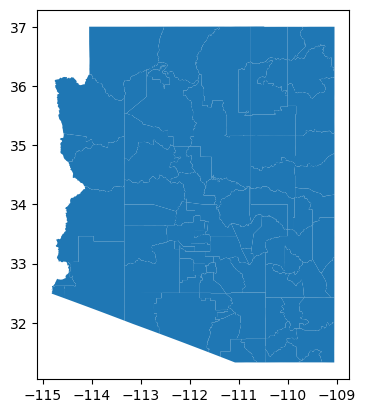

In [8]:
# View total arizona shapefile 
arizona.plot()

In [9]:
# View arizona dataset 
arizona.head(3)

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,015,91964,02582914,0401591964,Lake Havasu City,Lake Havasu City CCD,22,Z5,G4040,None,None,None,S,7493863105,50863803,+34.7686221,-113.8749805,"POLYGON ((-114.48778 34.71722, -114.48622 34.7..."
1,04,007,91277,02582913,0400791277,Fort Apache,Fort Apache CCD,22,Z5,G4040,None,None,None,S,2134058292,4388167,+33.8847663,-110.3394452,"POLYGON ((-110.78327 34.16750, -110.78276 34.1..."
2,04,003,90306,01934923,0400390306,Bisbee,Bisbee CCD,22,Z5,G4040,None,None,None,S,1610943633,3494169,+31.4580397,-110.0783372,"POLYGON ((-110.46089 31.47376, -110.46089 31.4..."


In [10]:
# Subset arizonia shapefile to arizonia subdivision
phoenix = arizona[arizona['NAME'] == "Phoenix"]
phoenix

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
46,04,013,92601,01934968,0401392601,Phoenix,Phoenix CCD,22,Z5,G4040,None,None,None,S,2805901266,10048820,+33.5211331,-112.0284405,"POLYGON ((-112.47014 33.55996, -112.47011 33.5..."


<Axes: >

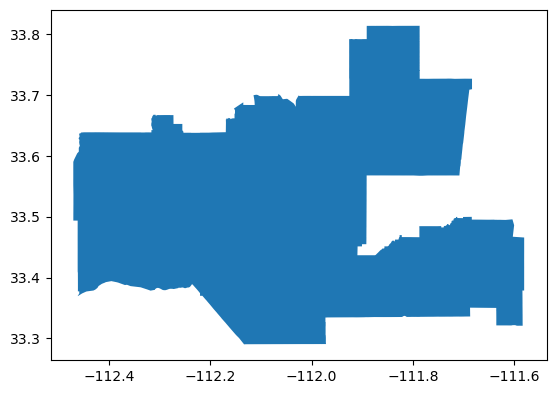

In [11]:
# View Phoenix subdivision map 
phoenix.plot()

In [12]:
# Convert the CRS of phoenix to match the CRS of the BII raster 
phoenix = phoenix.to_crs(bii_2017_data.rio.crs)
assert phoenix.crs == bii_2017_data.rio.crs

## Clip BII raster to Phoenix 

Now that the Phoenix shapefile and the BII rasters are in the same coordinate reference system, the raster can be clipped to the dimensions of Phoenix using the `geometry` column. 

In [13]:
# Clip rasters to Phoenix subdivision using rio.clip()
phoenix_bii_2017 = bii_2017_data.rio.clip(phoenix['geometry'])
phoenix_bii_2020 = bii_2020_data.rio.clip(phoenix['geometry'])

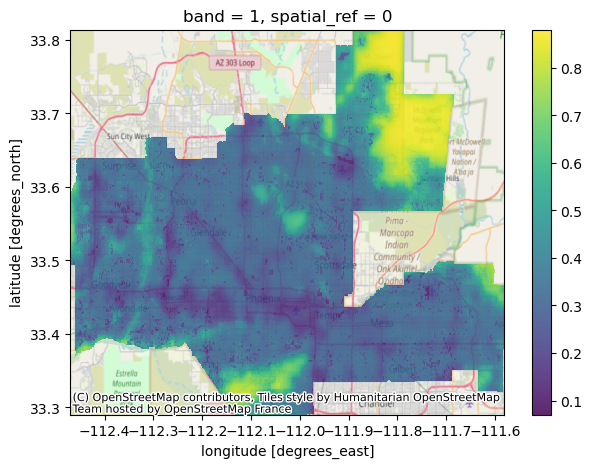

In [31]:
# View clipped data 
fig, ax = plt.subplots(figsize=(7, 5))  
phoenix_bii_2017.plot(ax=ax, alpha=0.85)  # plot raster

# Add the basemap
cx.add_basemap(ax, crs=phoenix_bii_2017.rio.crs)

plt.show()

## Calculate the change in BII from 2017 to 2020

In order to see how the Biodiversity Intactness Index changes from 2017 to 2020, the first step is to find the area of Phoenix with a BII of at least 0.75. Then, once the area is caluclated for both 2017 and 2020, then a raster of the difference of the area can highlight which areas BII have changed or decreased. 

In [33]:
# Select areas with BII > .75
phoenix_bii_2017_75 = phoenix_bii_2017 >= .75
phoenix_bii_2020_75 = phoenix_bii_2020 >= .75

# Assign data with true to 1 and false to 0 
bii_2017_75 = phoenix_bii_2017_75.astype('int') 
bii_2020_75 = phoenix_bii_2020_75.astype('int') 

# Sum the pixels above .75 (value = 1)
pixel_count_2017 = bii_2017_75.values.sum()
pixel_count_2020 = bii_2020_75.values.sum()

# Find percent pixels above .75 by dividing by total pixels
pct_area_2017 =  (pixel_count_2017 / phoenix_bii_2017.count().item())*100
pct_area_2020 =  (pixel_count_2020 / phoenix_bii_2020.count().item())*100

# Print the percentages 
print("% of area of Phoenix with BII > 75% in 2017: ", np.round(pct_area_2017, 2))
print("% of area of Phoenix with BII > 75% in 2020: ", np.round(pct_area_2020, 2))

% of area of Phoenix with BII > 75% in 2017:  7.13
% of area of Phoenix with BII > 75% in 2020:  6.49


Now that we have the percent area of land with BII above 75%, a raster that should the difference between the years can be created. 

In [34]:
# Create raster of the difference of BII>=0.75 between 2017 and 2020
difference = bii_2017_75 - bii_2020_75 

# Reclassify cells that aren't = 1 to be NA values 
difference = difference.where(difference ==1)